In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.impute import KNNImputer

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#change display options
pd.set_option("display.max_rows", 160)
pd.set_option("display.max_columns", 80)

In [2]:
# import datasets
df_train = pd.read_csv('../assets/train.csv')
df_spray = pd.read_csv('../assets/spray.csv')
df_weather = pd.read_csv('../assets/weather.csv')
map_data = np.loadtxt('../assets/mapdata_copyright_openstreetmap_contributors.txt')

Every year from late-May to early-October, public health workers in Chicago setup mosquito traps scattered across the city. Every week from Monday through Wednesday, these traps collect mosquitos, and the mosquitos are tested for the presence of West Nile virus before the end of the week. The test results include the number of mosquitos, the mosquitos species, and whether or not West Nile virus is present in the cohort. 

These test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50. 

The location of the traps are described by the block number and street name. For your convenience, we have mapped these attributes into Longitude and Latitude in the dataset. Please note that these are derived locations. For example, Block=79, and Street= "W FOSTER AVE" gives us an approximate address of "7900 W FOSTER AVE, Chicago, IL", which translates to (41.974089,-87.824812) on the map.

Some traps are "satellite traps". These are traps that are set up near (usually within 6 blocks) an established trap to enhance surveillance efforts. Satellite traps are postfixed with letters. For example, T220A is a satellite trap to T220. 

Please note that not all the locations are tested at all times. Also, records exist only when a particular species of mosquitos is found at a certain trap at a certain time. In the test set, we ask you for all combinations/permutations of possible predictions and are only scoring the observed ones.

- Id: the id of the record
- Date: date that the WNV test is performed
- Address: approximate address of the location of trap. This is used to send to the GeoCoder. 
- Species: the species of mosquitos
- Block: block number of address
- Street: street name
- Trap: Id of the trap
- AddressNumberAndStreet: approximate address returned from GeoCoder
- Latitude, Longitude: Latitude and Longitude returned from GeoCoder
- AddressAccuracy: accuracy returned from GeoCoder
- NumMosquitos: number of mosquitoes caught in this trap
- WnvPresent: whether West Nile Virus was present in these mosquitos. 1 means WNV is present, and 0 means not present. 

## Cleaning Datasets

### Train Dataset

In [3]:
df_train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


In [5]:
df_train.isnull().sum()

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

In [6]:
# converting Date in train dataset to python readable date-time format
df_train['Date'] = pd.to_datetime(df_train['Date'])

In [7]:
# Date range:
print(f'From:{df_train["Date"].min()}')
print(f"To:{df_train['Date'].max()}")

From:2007-05-29 00:00:00
To:2013-09-26 00:00:00


In [8]:
# set datetime column to be the index
df_train.set_index('Date', inplace=True)

##### Types of species and WNV breakdown

In [9]:
df_train["NumMosquitos"].sum()

135039

In [10]:
# for mosquitoes with West Nile Virus (Wnv)
df_train_1 = df_train[df_train["WnvPresent"]==1]
df_species_1 = pd.DataFrame(df_train_1.groupby("Species").NumMosquitos.sum())
df_species_1["Wnv"] = "With WNV"
df_species_1.sort_values("NumMosquitos",ascending = False)

,NumMosquitos,Wnv
Species,,
CULEX PIPIENS/RESTUANS,7123,With WNV
CULEX PIPIENS,6729,With WNV
CULEX RESTUANS,667,With WNV


In [11]:
# for mosquitoes without West Nile Virus (Wnv)
df_train_0 = df_train[df_train["WnvPresent"]==0]
df_species_0 = pd.DataFrame(df_train_0.groupby("Species").NumMosquitos.sum())
df_species_0["Wnv"] = "Without WNV"
df_species_0.sort_values("NumMosquitos",ascending = False)

,NumMosquitos,Wnv
Species,,
CULEX PIPIENS/RESTUANS,59145,Without WNV
CULEX PIPIENS,37942,Without WNV
CULEX RESTUANS,22764,Without WNV
CULEX TERRITANS,510,Without WNV
CULEX SALINARIUS,145,Without WNV
CULEX ERRATICUS,7,Without WNV
CULEX TARSALIS,7,Without WNV


In [12]:
# append both dataframes
df_species = df_species_1.append(df_species_0)
df_species

,NumMosquitos,Wnv
Species,,
CULEX PIPIENS,6729,With WNV
CULEX PIPIENS/RESTUANS,7123,With WNV
CULEX RESTUANS,667,With WNV
CULEX ERRATICUS,7,Without WNV
CULEX PIPIENS,37942,Without WNV
CULEX PIPIENS/RESTUANS,59145,Without WNV
CULEX RESTUANS,22764,Without WNV
CULEX SALINARIUS,145,Without WNV
CULEX TARSALIS,7,Without WNV


<AxesSubplot:xlabel='Species', ylabel='NumMosquitos'>

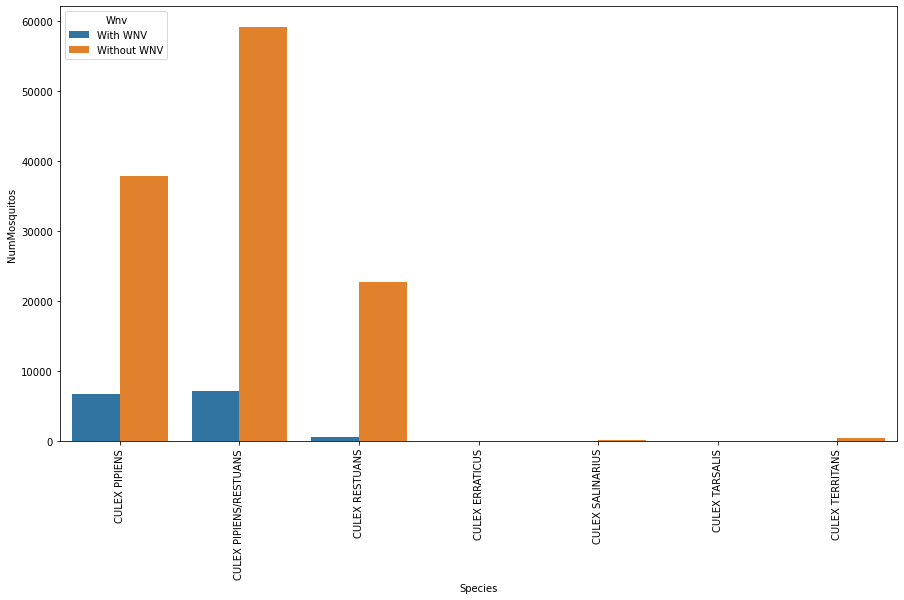

In [13]:
# Mosquito species with/without WNV
plt.figure(figsize =(15,8))
plt.xticks(rotation=90)
sns.barplot(data=df_species, x=df_species.index, y='NumMosquitos', hue='Wnv')

In [14]:
# number of mosquitoes by month
df_train_month= df_train.resample('M').sum()
df_train_month

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Date,,,,,,
2007-05-31,906,1046.922110,-2192.404258,198,40,0
2007-06-30,6785,7372.235940,-15438.182215,1445,428,0
2007-07-31,20375,24054.623636,-50416.795695,4355,7199,6
2007-08-31,70357,85680.150076,-179697.722776,14984,40015,200
2007-09-30,27669,32362.336845,-67855.829751,5786,9300,28
2007-10-31,8331,8827.495979,-18501.717362,1665,1706,2
2007-11-30,0,0.000000,0.000000,0,0,0
2007-12-31,0,0.000000,0.000000,0,0,0
2008-01-31,0,0.000000,0.000000,0,0,0


In [15]:
# number of mosquitoes by year
df_train_year = df_train.resample('Y').sum()
df_train_year

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Date,,,,,,
2007-12-31,134423,159343.764586,-334102.652057,28433,58688,236
2008-12-31,0,0.000000,0.000000,0,0,0
2009-12-31,75859,94135.134226,-197283.868462,18008,21108,19
2010-12-31,0,0.000000,0.000000,0,0,0
2011-12-31,72699,85982.887135,-180181.751753,16399,18799,57
2012-12-31,0,0.000000,0.000000,0,0,0
2013-12-31,91955,100121.223431,-209806.961000,19312,36444,239


Text(0.5, 0, 'Time')

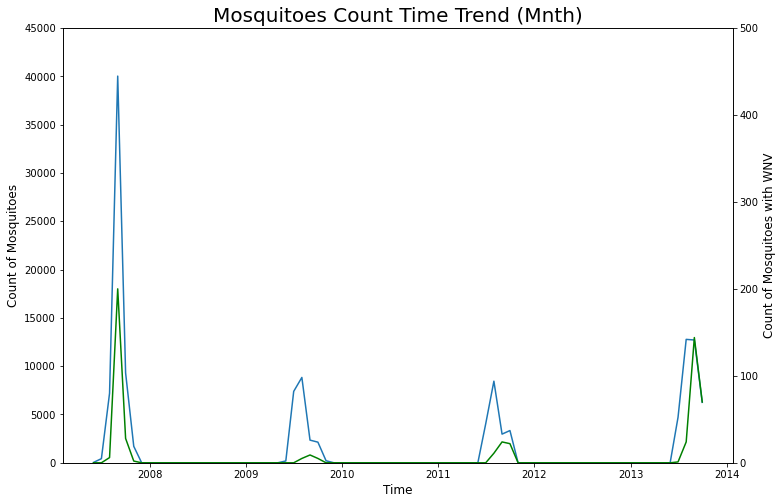

In [16]:
# Number of mosquitoes time trend (month):
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(df_train_month['NumMosquitos'])
ax2 = ax1.twinx()
ax2.plot(df_train_month['WnvPresent'], color = "green")
ax1.set_ylim([0, 45000])
ax2.set_ylim([0, 500])
plt.title("Mosquitoes Count Time Trend (Mnth)", fontsize = 20)
ax1.set_ylabel("Count of Mosquitoes", fontsize = 12)
ax2.set_ylabel("Count of Mosquitoes with WNV",fontsize = 12)
ax1.set_xlabel("Time", fontsize = 12)

In [17]:
# To shows that there are periods of time without data collected
df_train.index.unique()

DatetimeIndex(['2007-05-29', '2007-06-05', '2007-06-26', '2007-06-29',
               '2007-07-02', '2007-07-11', '2007-07-18', '2007-07-19',
               '2007-07-25', '2007-07-27', '2007-08-01', '2007-08-02',
               '2007-08-03', '2007-08-07', '2007-08-08', '2007-08-09',
               '2007-08-15', '2007-08-16', '2007-08-17', '2007-08-21',
               '2007-08-22', '2007-08-24', '2007-08-28', '2007-09-04',
               '2007-09-05', '2007-09-06', '2007-09-12', '2007-09-18',
               '2007-09-19', '2007-09-24', '2007-09-25', '2007-10-04',
               '2007-10-09', '2009-05-28', '2009-06-02', '2009-06-03',
               '2009-06-05', '2009-06-12', '2009-06-15', '2009-06-19',
               '2009-06-22', '2009-06-26', '2009-06-29', '2009-07-06',
               '2009-07-10', '2009-07-13', '2009-07-17', '2009-07-24',
               '2009-07-27', '2009-07-31', '2009-08-07', '2009-08-13',
               '2009-08-25', '2009-08-27', '2009-09-03', '2009-09-14',
      

Text(0.5, 0, 'Time')

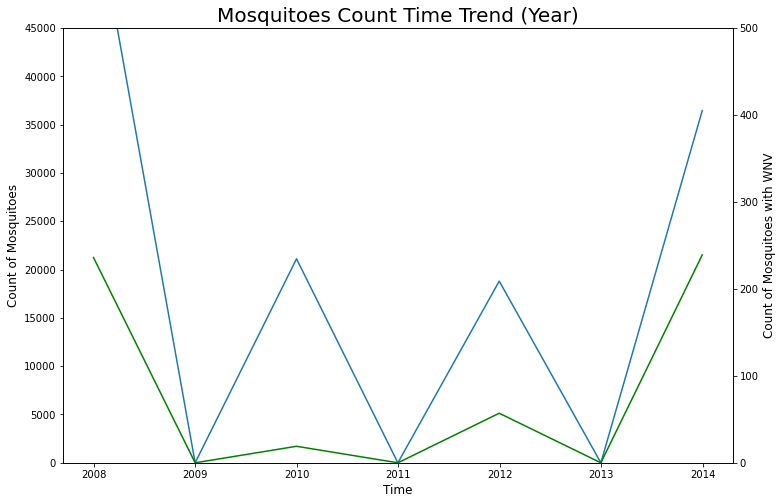

In [18]:
# Number of mosquitoes time trend (month):
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(df_train_year['NumMosquitos'])
ax2 = ax1.twinx()
ax2.plot(df_train_year['WnvPresent'], color = "green")
ax1.set_ylim([0, 45000])
ax2.set_ylim([0, 500])
plt.title("Mosquitoes Count Time Trend (Year)", fontsize = 20)
ax1.set_ylabel("Count of Mosquitoes", fontsize = 12)
ax2.set_ylabel("Count of Mosquitoes with WNV",fontsize = 12)
ax1.set_xlabel("Time", fontsize = 12)

##### Location

In [19]:
# Top 15 locations with most Mosquitoes:
df_train_top = df_train.groupby("Trap").NumMosquitos.sum().sort_values(ascending = False).head(15)
df_train_top

Trap
T115    21668
T900    15386
T138     9936
T002     3710
T128     3315
T135     3122
T103     2988
T008     2668
T212     2595
T158     2575
T903     2327
T114     2161
T225     2014
T151     1969
T009     1940
Name: NumMosquitos, dtype: int64

In [20]:
# for mosquitoes without West Nile Virus (Wnv)
df_loc_0 = pd.DataFrame(df_train_0.groupby("Trap").NumMosquitos.sum())
df_loc_0["Wnv"] = "Without WNV"
df_loc_0.sort_values("NumMosquitos",ascending = False)

,NumMosquitos,Wnv
Trap,,
T115,19790,Without WNV
T900,13326,Without WNV
T138,9177,Without WNV
T002,3210,Without WNV
T128,2833,Without WNV
T135,2806,Without WNV
T103,2715,Without WNV
T212,2500,Without WNV
T158,2389,Without WNV


In [21]:
# for mosquitoes with West Nile Virus (Wnv)
df_loc_1 = pd.DataFrame(df_train_1.groupby("Trap").NumMosquitos.sum())
df_loc_1["Wnv"] = "With WNV"
df_loc_1.sort_values("NumMosquitos",ascending = False)

,NumMosquitos,Wnv
Trap,,
T900,2060,With WNV
T115,1878,With WNV
T138,759,With WNV
T002,500,With WNV
T128,482,With WNV
T003,380,With WNV
T008,330,With WNV
T135,316,With WNV
T013,316,With WNV


In [22]:
# append both dataframes
df_loc = df_loc_1.append(df_loc_0)
df_loc

,NumMosquitos,Wnv
Trap,,
T002,500,With WNV
T003,380,With WNV
T005,17,With WNV
T006,46,With WNV
T008,330,With WNV
...,...,...
T236,365,Without WNV
T237,18,Without WNV
T238,34,Without WNV


In [23]:
# filter out to top 15 locations with most mosquitoes
df_loc_filter = df_loc.loc[['T115', 'T900', 'T138', 'T002', 'T128', 'T135', 'T103', 'T008', 'T212',
       'T158', 'T903', 'T114', 'T225', 'T151', 'T009'],:]

<AxesSubplot:xlabel='Trap', ylabel='NumMosquitos'>

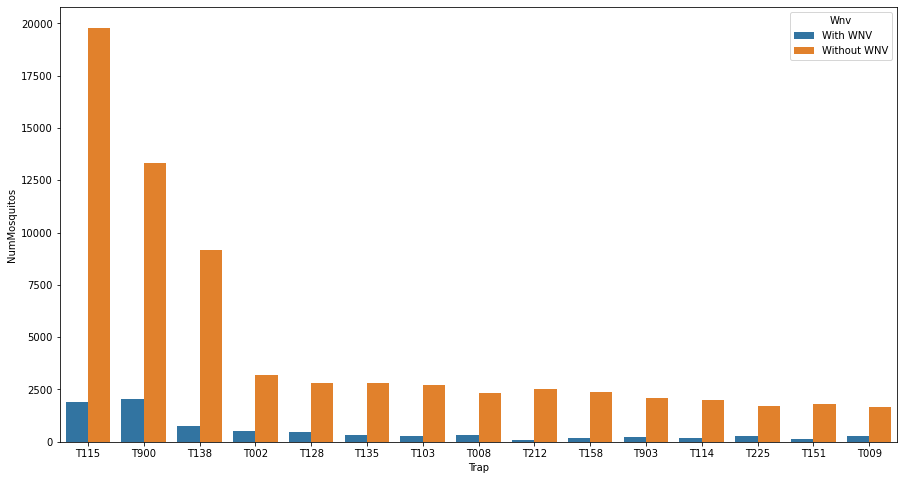

In [24]:
# Mosquito counts with/without WNV for locations in top 15 
plt.figure(figsize =(15,8))
sns.barplot(data=df_loc_filter, x=df_loc_filter.index, y='NumMosquitos', hue='Wnv')

In [25]:
df_train.groupby("AddressAccuracy").Trap.count()

AddressAccuracy
3      91
5    1807
8    4628
9    3980
Name: Trap, dtype: int64

### Spray Dataset

The City of Chicago also does spraying to kill mosquitos. You are given the GIS data for their spray efforts in 2011 and 2013. Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus. 

In [26]:
df_spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [27]:
df_spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [28]:
df_spray.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

In [29]:
df_spray.head(10)

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858
5,2011-08-29,6:57:48 PM,42.390395,-88.088315
6,2011-08-29,6:57:58 PM,42.390673,-88.088002
7,2011-08-29,6:58:08 PM,42.391027,-88.088002
8,2011-08-29,6:58:18 PM,42.391403,-88.088003
9,2011-08-29,6:58:28 PM,42.391718,-88.087995


In [30]:
# Check that null values from Time column only occurs for 2011-09-07
df_spray[df_spray["Time"].isnull()].groupby("Date").Latitude.count()

Date
2011-09-07    584
Name: Latitude, dtype: int64

In [31]:
# Mode/Median for spray timing on 2011-09-07
print(f'Mode: {pd.to_datetime(df_spray[df_spray["Date"]=="2011-09-07"]["Time"]).mode()}')
print(f'Median: {pd.to_datetime(df_spray[df_spray["Date"]=="2011-09-07"]["Time"]).median()}')
print(f'Min: {pd.to_datetime(df_spray[df_spray["Date"]=="2011-09-07"]["Time"]).min()}')
print(f'Max: {pd.to_datetime(df_spray[df_spray["Date"]=="2011-09-07"]["Time"]).max()}')

Mode: 0   2022-12-08 19:44:32
Name: Time, dtype: datetime64[ns]
Median: 2022-12-08 20:11:06
Min: 2022-12-08 19:42:12
Max: 2022-12-08 21:41:10


Text(0.5, 0, 'Time')

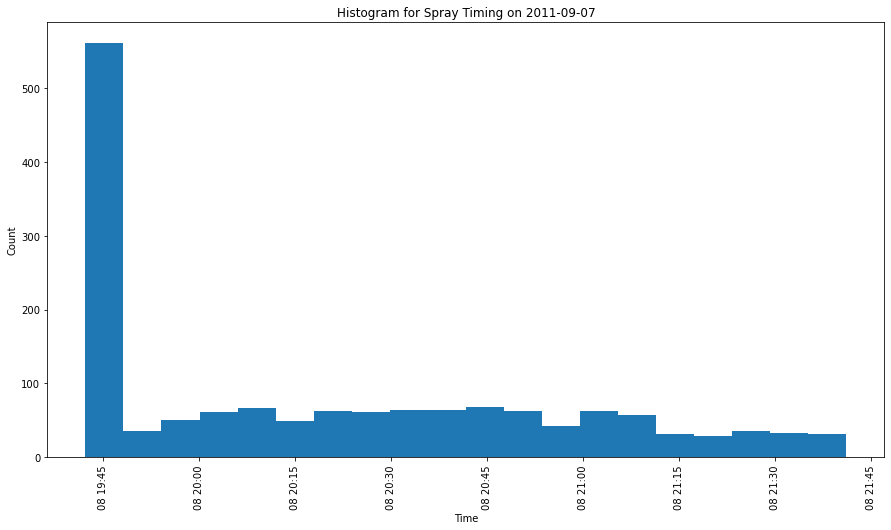

In [32]:
# Plotting histogram of spray timing
df_spray_0907 = df_spray[df_spray["Date"]=='2011-09-07']
plt.figure(figsize =(15,8))
plt.xticks(rotation=90)
df_spray_1 = df_spray_0907[df_spray_0907["Time"].notnull()]
plt.hist(pd.to_datetime(df_spray_1['Time']),bins = 20)
plt.title("Histogram for Spray Timing on 2011-09-07")
plt.ylabel("Count")
plt.xlabel("Time")

In [33]:
# replacing null values in df_spray "Time" column with mode timing
df_spray["Time"].fillna("7:44:32 PM", inplace = True)
df_spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14835 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [34]:
#create datetime column:
df_spray["datetime"] = df_spray["Date"] + " " + df_spray["Time"]
df_spray.head()

,Date,Time,Latitude,Longitude,datetime
0,2011-08-29,6:56:58 PM,42.391623,-88.089163,2011-08-29 6:56:58 PM
1,2011-08-29,6:57:08 PM,42.391348,-88.089163,2011-08-29 6:57:08 PM
2,2011-08-29,6:57:18 PM,42.391022,-88.089157,2011-08-29 6:57:18 PM
3,2011-08-29,6:57:28 PM,42.390637,-88.089158,2011-08-29 6:57:28 PM
4,2011-08-29,6:57:38 PM,42.390410,-88.088858,2011-08-29 6:57:38 PM


In [35]:
# converting to python readable date-time format
df_spray['datetime'] = pd.to_datetime(df_spray['datetime'])

In [36]:
# set datetime column to be the index
df_spray.set_index('datetime', inplace=True)

In [37]:
df_spray.tail()

,Date,Time,Latitude,Longitude
datetime,,,,
2013-09-05 20:34:11,2013-09-05,8:34:11 PM,42.006587,-87.812355
2013-09-05 20:35:01,2013-09-05,8:35:01 PM,42.006192,-87.816015
2013-09-05 20:35:21,2013-09-05,8:35:21 PM,42.006022,-87.817392
2013-09-05 20:35:31,2013-09-05,8:35:31 PM,42.005453,-87.817423
2013-09-05 20:35:41,2013-09-05,8:35:41 PM,42.004805,-87.817460


In [38]:
# hist
df_spray_day = df_spray.resample("D").count()
df_spray_day

,Date,Time,Latitude,Longitude
datetime,,,,
2011-08-29,95,95,95,95
2011-08-30,0,0,0,0
2011-08-31,0,0,0,0
2011-09-01,0,0,0,0
2011-09-02,0,0,0,0
...,...,...,...,...
2013-09-01,0,0,0,0
2013-09-02,0,0,0,0
2013-09-03,0,0,0,0


In [39]:
df_spray_month = df_spray_day.resample("M").count()
df_spray_month

,Date,Time,Latitude,Longitude
datetime,,,,
2011-08-31,3,3,3,3
2011-09-30,30,30,30,30
2011-10-31,31,31,31,31
2011-11-30,30,30,30,30
2011-12-31,31,31,31,31
2012-01-31,31,31,31,31
2012-02-29,29,29,29,29
2012-03-31,31,31,31,31
2012-04-30,30,30,30,30


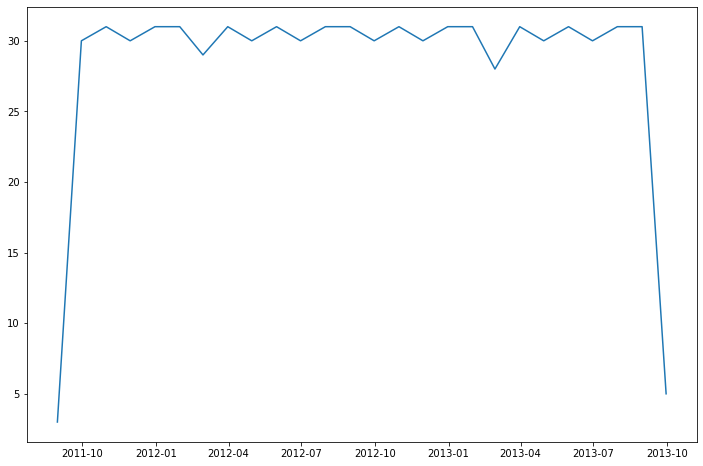

In [40]:
plt.figure(figsize=(12,8))
plt.plot(df_spray_month["Date"])

### Weather

It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. We provide you with the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests. 

Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [41]:
df_weather.head(50)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
5,2,2007-05-03,67,48,58,M,40,50,7,0,-,-,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
6,1,2007-05-04,66,49,58,4,41,50,7,0,0444,1852,RA,0,M,0.0,T,29.31,30.05,10.4,8,10.8
7,2,2007-05-04,78,51,M,M,42,50,M,M,-,-,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
8,1,2007-05-05,66,53,60,5,38,49,5,0,0443,1853,,0,M,0.0,T,29.40,30.10,11.7,7,12.0
9,2,2007-05-05,66,54,60,M,39,50,5,0,-,-,,M,M,M,T,29.46,30.09,11.2,7,11.5


In [42]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [43]:
# converting Date in train dataset to python readable date-time format
df_weather['Date'] = pd.to_datetime(df_weather['Date'])

In [44]:
# set datetime column to be the index
df_weather.set_index('Date', inplace=True)

In [45]:
df_weather.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
2007-05-01,2,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2007-05-02,1,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
2007-05-02,2,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
2007-05-03,1,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [46]:
# replace M with NaN
df_weather.replace(to_replace= "M", value=np.NaN, inplace = True)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2944 entries, 2007-05-01 to 2014-10-31
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Tmax         2944 non-null   int64  
 2   Tmin         2944 non-null   int64  
 3   Tavg         2933 non-null   object 
 4   Depart       1472 non-null   object 
 5   DewPoint     2944 non-null   int64  
 6   WetBulb      2940 non-null   object 
 7   Heat         2933 non-null   object 
 8   Cool         2933 non-null   object 
 9   Sunrise      2944 non-null   object 
 10  Sunset       2944 non-null   object 
 11  CodeSum      2944 non-null   object 
 12  Depth        1472 non-null   object 
 13  Water1       0 non-null      float64
 14  SnowFall     1472 non-null   object 
 15  PrecipTotal  2942 non-null   object 
 16  StnPressure  2940 non-null   object 
 17  SeaLevel     2935 non-null   object 
 18  ResultSpeed  2944 non-null   f

##### Tavg

In [47]:
# replacing missing values in Tavg with cal avg of Tmax and Tmin 
df_weather["Tavg"] = df_weather.loc[:,["Tmax","Tmin"]].mean(axis = 1).apply(np.ceil)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2944 entries, 2007-05-01 to 2014-10-31
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Tmax         2944 non-null   int64  
 2   Tmin         2944 non-null   int64  
 3   Tavg         2944 non-null   float64
 4   Depart       1472 non-null   object 
 5   DewPoint     2944 non-null   int64  
 6   WetBulb      2940 non-null   object 
 7   Heat         2933 non-null   object 
 8   Cool         2933 non-null   object 
 9   Sunrise      2944 non-null   object 
 10  Sunset       2944 non-null   object 
 11  CodeSum      2944 non-null   object 
 12  Depth        1472 non-null   object 
 13  Water1       0 non-null      float64
 14  SnowFall     1472 non-null   object 
 15  PrecipTotal  2942 non-null   object 
 16  StnPressure  2940 non-null   object 
 17  SeaLevel     2935 non-null   object 
 18  ResultSpeed  2944 non-null   f

##### Depart

In [48]:
# breaking down dataset into respective stations
df_weather_1 = df_weather[df_weather["Station"]==1]
df_weather_2 = df_weather[df_weather["Station"]==2]

In [49]:
# checking missing values in Depart column
display(df_weather_1.info())
display(df_weather_2.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1472 entries, 2007-05-01 to 2014-10-31
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      1472 non-null   int64  
 1   Tmax         1472 non-null   int64  
 2   Tmin         1472 non-null   int64  
 3   Tavg         1472 non-null   float64
 4   Depart       1472 non-null   object 
 5   DewPoint     1472 non-null   int64  
 6   WetBulb      1469 non-null   object 
 7   Heat         1472 non-null   object 
 8   Cool         1472 non-null   object 
 9   Sunrise      1472 non-null   object 
 10  Sunset       1472 non-null   object 
 11  CodeSum      1472 non-null   object 
 12  Depth        1472 non-null   object 
 13  Water1       0 non-null      float64
 14  SnowFall     1472 non-null   object 
 15  PrecipTotal  1472 non-null   object 
 16  StnPressure  1470 non-null   object 
 17  SeaLevel     1467 non-null   object 
 18  ResultSpeed  1472 non-null   f

None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1472 entries, 2007-05-01 to 2014-10-31
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      1472 non-null   int64  
 1   Tmax         1472 non-null   int64  
 2   Tmin         1472 non-null   int64  
 3   Tavg         1472 non-null   float64
 4   Depart       0 non-null      object 
 5   DewPoint     1472 non-null   int64  
 6   WetBulb      1471 non-null   object 
 7   Heat         1461 non-null   object 
 8   Cool         1461 non-null   object 
 9   Sunrise      1472 non-null   object 
 10  Sunset       1472 non-null   object 
 11  CodeSum      1472 non-null   object 
 12  Depth        0 non-null      object 
 13  Water1       0 non-null      float64
 14  SnowFall     0 non-null      object 
 15  PrecipTotal  1470 non-null   object 
 16  StnPressure  1470 non-null   object 
 17  SeaLevel     1468 non-null   object 
 18  ResultSpeed  1472 non-null   f

None

Text(0.5, 0, 'Time')

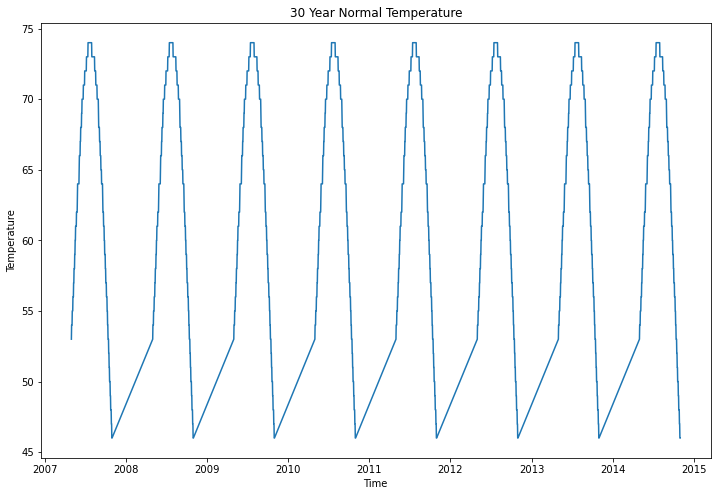

In [50]:
# calculate 30 year normal temperature from station 1 and merge to station 2 dataset
df_weather_1["Depart"] = df_weather_1["Depart"].astype(float)
df_weather_2["30_yr_temp"] = df_weather_1["Tavg"] - df_weather_1["Depart"]

# plotting trend for 30 year normal temperature
plt.figure(figsize=(12,8))
plt.plot(df_weather_2["30_yr_temp"])
plt.title("30 Year Normal Temperature")
plt.ylabel("Temperature")
plt.xlabel("Time")

In [51]:
# Calculate Depart value for station 2
df_weather_2["Depart"] = df_weather_2["Tavg"] - df_weather_2["30_yr_temp"]
df_weather_2.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,30_yr_temp
Date,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,2,84,52,68.0,15.0,51,57,0,3,-,-,,NaN,NaN,NaN,0.00,29.18,29.82,2.7,25,9.6,53.0
2007-05-02,2,60,43,52.0,-2.0,42,47,13,0,-,-,BR HZ,NaN,NaN,NaN,0.00,29.44,30.08,13.3,2,13.4,54.0
2007-05-03,2,67,48,58.0,4.0,40,50,7,0,-,-,HZ,NaN,NaN,NaN,0.00,29.46,30.12,12.9,6,13.2,54.0
2007-05-04,2,78,51,65.0,11.0,42,50,NaN,NaN,-,-,,NaN,NaN,NaN,0.00,29.36,30.04,10.1,7,10.4,54.0
2007-05-05,2,66,54,60.0,5.0,39,50,5,0,-,-,,NaN,NaN,NaN,T,29.46,30.09,11.2,7,11.5,55.0


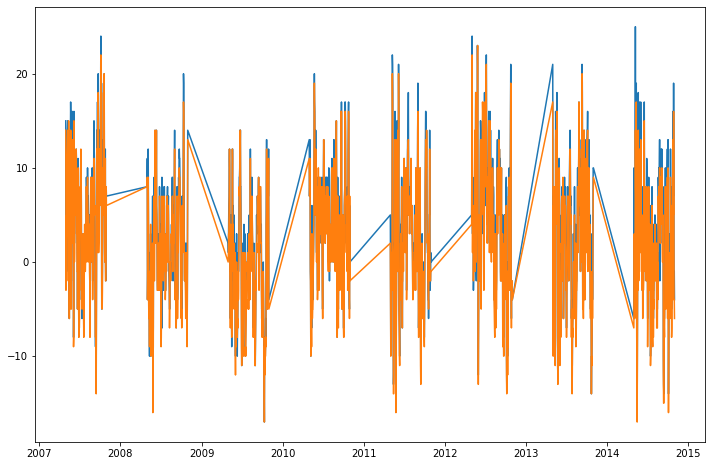

In [52]:
plt.figure(figsize=(12,8))
plt.plot(df_weather_2["Depart"])
plt.plot(df_weather_1["Depart"])

##### Wet Bulb

In [53]:
# checking for null values
display(df_weather_1[df_weather_1["WetBulb"].isnull()])
display(df_weather_2[df_weather_2["WetBulb"].isnull()])

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2009-06-26,1,86,69,78.0,7.0,60,NaN,0,13,0418,1931,,0,NaN,0.0,0.00,NaN,29.85,6.4,4,8.2
2013-08-10,1,81,64,73.0,0.0,57,NaN,0,8,0454,1900,,0,NaN,0.0,0.00,NaN,30.08,5.3,5,6.5
2013-08-11,1,81,60,71.0,-2.0,61,NaN,0,6,0455,1859,RA,0,NaN,0.0,0.01,29.35,30.07,2.0,27,3.0


,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,30_yr_temp
Date,,,,,,,,,,,,,,,,,,,,,,
2013-08-12,2,85,69,77.0,4.0,63,NaN,0,12,-,-,RA,NaN,NaN,NaN,0.66,29.27,29.92,4.5,26,7.7,73.0


In [54]:
# replace null values
df_weather_1["WetBulb"]=df_weather_1["WetBulb"].fillna(method="ffill").astype(float)

##### Heat/Cool

In [55]:
# Port over Heat values from station 1 to replace null values
for i in df_weather_2.index:
    if df_weather_2.loc[i,"Heat"] is np.NaN:
        df_weather_2.loc[i,"Heat"] = df_weather_1.loc[i,"Heat"]
        
# Port over Cool values from station 1 to replace null values
for i in df_weather_2.index:
    if df_weather_2.loc[i,"Cool"] is np.NaN:
        df_weather_2.loc[i,"Cool"] = df_weather_1.loc[i,"Cool"]

In [56]:
df_weather_1["Heat"] = df_weather_1["Heat"].astype(float) 

In [57]:
df_weather_1["Cool"] = df_weather_1["Cool"].astype(float) 

#### Sunrise/Sunset

In [100]:
# convert to python readable time format
df_weather_1["Sunrise_1"] = pd.to_datetime(df_weather_1['Sunrise'], format='%H:%M')

ValueError: time data '0448' does not match format '%H:%M' (match)

In [98]:
df_weather_1["Sunrise_1"].unique()

array(['1900-01-01T04:48:00.000000000', '1900-01-01T04:47:00.000000000',
       '1900-01-01T04:46:00.000000000', '1900-01-01T04:44:00.000000000',
       '1900-01-01T04:43:00.000000000', '1900-01-01T04:42:00.000000000',
       '1900-01-01T04:41:00.000000000', '1900-01-01T04:39:00.000000000',
       '1900-01-01T04:38:00.000000000', '1900-01-01T04:37:00.000000000',
       '1900-01-01T04:36:00.000000000', '1900-01-01T04:35:00.000000000',
       '1900-01-01T04:34:00.000000000', '1900-01-01T04:33:00.000000000',
       '1900-01-01T04:32:00.000000000', '1900-01-01T04:31:00.000000000',
       '1900-01-01T04:30:00.000000000', '1900-01-01T04:29:00.000000000',
       '1900-01-01T04:28:00.000000000', '1900-01-01T04:27:00.000000000',
       '1900-01-01T04:26:00.000000000', '1900-01-01T04:25:00.000000000',
       '1900-01-01T04:24:00.000000000', '1900-01-01T04:23:00.000000000',
       '1900-01-01T04:22:00.000000000', '1900-01-01T04:21:00.000000000',
       '1900-01-01T04:20:00.000000000', '1900-01-01

In [89]:
df_weather_1["Sunset"].unique()

array(['1849', '1850', '1851', '1852', '1853', '1855', '1856', '1857',
       '1858', '1859', '1860', '1901', '1902', '1903', '1904', '1905',
       '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913',
       '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921',
       '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929',
       '1930', '1931', '1900', '1854', '1848', '1846', '1845', '1843',
       '1842', '1840', '1839', '1837', '1835', '1834', '1832', '1831',
       '1829', '1827', '1826', '1824', '1822', '1821', '1819', '1817',
       '1815', '1814', '1812', '1810', '1809', '1807', '1805', '1803',
       '1760', '1758', '1756', '1755', '1753', '1751', '1749', '1748',
       '1746', '1744', '1742', '1741', '1739', '1737', '1735', '1734',
       '1732', '1730', '1729', '1727', '1725', '1724', '1722', '1720',
       '1719', '1717', '1715', '1714', '1712', '1711', '1709', '1707',
       '1706', '1704', '1703', '1701', '1660', '1658', '1657', '1656',
      

In [99]:
# convert to python readable time format
df_weather_1["Sunset_1"] = pd.to_datetime(df_weather_1['Sunset'], format='%H:%M')

ValueError: time data '1849' does not match format '%H:%M' (match)

##### Codesum

In [67]:
# replace blank values with Clear
df_weather_1["CodeSum"].replace(to_replace=' ',value="Clear", inplace = True)

In [68]:
df_weather_1["CodeSum"].unique()

array(['Clear', 'BR', 'RA', 'BR HZ', 'RA BR', 'RA VCTS', 'RA HZ',
       'TSRA RA BR HZ', 'HZ', 'TSRA BR HZ', 'TSRA RA BR', 'TSRA RA HZ',
       'TSRA BR HZ VCTS', 'TSRA', 'TSRA BR HZ FU', 'BR HZ FU',
       'TSRA RA VCTS', 'HZ VCTS', 'RA BR VCTS', 'TSRA RA BR VCTS',
       'DZ BR', 'TS TSRA RA BR HZ', 'RA BR HZ', 'TSRA RA',
       'TS TSRA RA BR', 'TS RA BR', 'TS TSRA RA', 'TS TSRA RA BR VCTS',
       'TS RA', 'TSRA BR', 'RA DZ FG+ BCFG BR', 'RA FG+ MIFG BR', 'RA DZ',
       'RA DZ BR', 'TSRA RA FG+ FG BR', 'TSRA DZ FG+ FG BR HZ', 'TS TSRA',
       'TSRA HZ', 'TS', 'FG+ BR HZ', 'TS TSRA BR HZ', 'DZ BR HZ',
       'TS TSRA BR', 'RA BR FU', 'TS BR HZ', 'FG+ BR', 'FG+ MIFG BR',
       'TSRA RA FG BR', 'DZ', 'RA DZ BR HZ', 'TS BR', 'TS RA FG+ FG BR',
       'RA DZ FG+ FG BR', 'RA BR SQ', 'RA FG BR', 'RA BR HZ FU',
       'MIFG BCFG BR', 'TSRA RA FG+ FG BR HZ', 'TSRA DZ BR HZ',
       'TS TSRA RA FG BR HZ', 'RA DZ FG+ BR', 'TSRA FG+ BR HZ',
       'FG+ FG BR HZ', 'FG BR HZ', 'TS RA BR HZ',

##### Depth

In [69]:
# check on Depth unique values
df_weather_1["Depth"].unique()

array(['0'], dtype=object)

In [70]:
# drop Depth since all 0 values
df_weather_1.drop("Depth", axis = 1, inplace = True)

##### Water1

In [71]:
# drop Water1, since all null values
df_weather_1.drop("Water1", axis = 1, inplace = True)

##### SnowFall

In [72]:
# check on SnowFall unique values
df_weather_1["SnowFall"].unique()

array(['0.0', '  T', '0.1'], dtype=object)

In [73]:
# replace Trace values with 0 - since a trace is anything less than can be measured
df_weather_1["SnowFall"].replace(to_replace= '  T', value="0.0", inplace = True)

# change to float datatype
df_weather_1["SnowFall"] = df_weather_1["SnowFall"].astype(float)

#### Precipitotal

In [74]:
df_weather_1["PrecipTotal"].unique()

array(['0.00', '  T', '0.13', '0.38', '0.14', '0.07', '0.02', '1.01',
       '0.04', '0.01', '0.19', '0.39', '0.42', '0.28', '0.58', '0.05',
       '0.16', '0.15', '0.40', '0.30', '0.43', '0.11', '1.55', '0.17',
       '0.03', '1.43', '0.26', '1.31', '0.06', '0.29', '0.41', '0.23',
       '0.09', '1.33', '0.91', '0.37', '2.35', '0.24', '0.34', '0.18',
       '0.36', '0.27', '0.33', '1.28', '0.76', '0.95', '0.08', '0.12',
       '0.48', '0.52', '0.64', '1.24', '0.20', '0.72', '0.73', '1.61',
       '0.74', '1.05', '2.43', '2.90', '1.23', '6.64', '1.44', '0.82',
       '0.80', '0.32', '0.67', '0.55', '1.73', '0.44', '0.45', '3.97',
       '0.25', '0.68', '0.63', '0.35', '0.93', '0.22', '0.75', '0.89',
       '0.21', '0.46', '1.03', '0.60', '0.81', '0.97', '1.49', '1.02',
       '0.59', '0.87', '0.85', '0.54', '0.79', '2.79', '3.64', '0.10',
       '0.31', '2.24', '1.06', '1.88', '6.86', '0.71', '0.70', '1.11',
       '0.65', '1.21', '0.77', '1.34', '0.47', '1.12', '0.57', '0.51',
       

In [75]:
# replace Trace values with 0 - since a trace is anything less than can be measured
df_weather_1["PrecipTotal"].replace(to_replace= '  T', value="0.00", inplace = True)

# change to float datatype
df_weather_1["PrecipTotal"] = df_weather_1["PrecipTotal"].astype(float)

#### StnPressure

In [76]:
# fill null values for StnPressure with previous day values
df_weather_1["StnPressure"] = df_weather_1["StnPressure"].fillna(method="ffill").astype(float)

#### SeaLevel

In [77]:
# fill null values for SeaLevel with previous day values
df_weather_1["SeaLevel"] = df_weather_1["SeaLevel"].fillna(method="ffill").astype(float)

#### AvgSpeed

In [78]:
df_weather_1["AvgSpeed"] = df_weather_1["AvgSpeed"].astype(float)

In [79]:
df_weather_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1472 entries, 2007-05-01 to 2014-10-31
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      1472 non-null   int64         
 1   Tmax         1472 non-null   int64         
 2   Tmin         1472 non-null   int64         
 3   Tavg         1472 non-null   float64       
 4   Depart       1472 non-null   float64       
 5   DewPoint     1472 non-null   int64         
 6   WetBulb      1472 non-null   float64       
 7   Heat         1472 non-null   float64       
 8   Cool         1472 non-null   float64       
 9   Sunrise      1472 non-null   object        
 10  Sunset       1472 non-null   object        
 11  CodeSum      1472 non-null   object        
 12  SnowFall     1472 non-null   float64       
 13  PrecipTotal  1472 non-null   float64       
 14  StnPressure  1472 non-null   float64       
 15  SeaLevel     1472 non-null   float64 

In [80]:
# cal delta between Temperature readings for station 1 and station 2
df_weather_1["Tmax_delta"] = df_weather_1["Tmax"]-df_weather_2["Tmax"]
df_weather_1["Tmin_delta"] = df_weather_1["Tmin"]-df_weather_2["Tmin"]

Text(0.5, 0, 'Time')

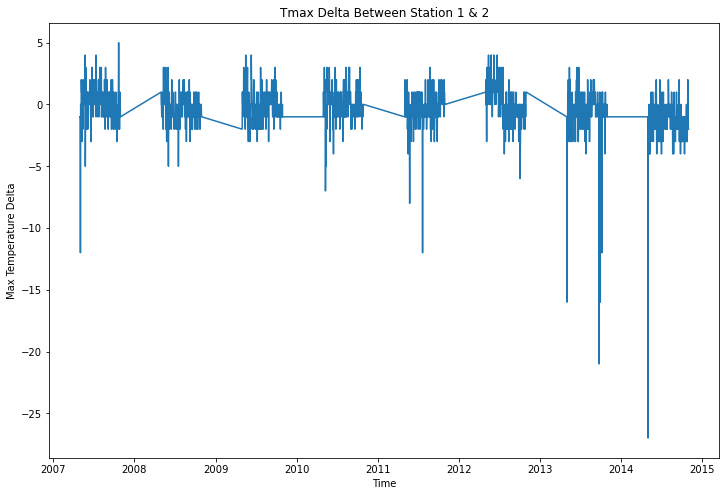

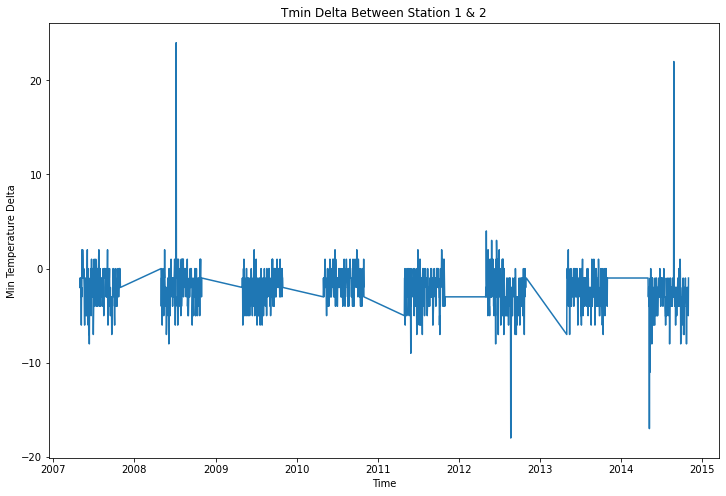

In [81]:
plt.figure(figsize=(12,8))
plt.plot(df_weather_1["Tmax_delta"])
plt.title("Tmax Delta Between Station 1 & 2")
plt.ylabel("Max Temperature Delta")
plt.xlabel("Time")

plt.figure(figsize=(12,8))
plt.plot(df_weather_1["Tmin_delta"])
plt.title("Tmin Delta Between Station 1 & 2")
plt.ylabel("Min Temperature Delta")
plt.xlabel("Time")

In [82]:
df_weather[df_weather["Depart"]=="M"]["Station"].unique()

array([], dtype=int64)

In [83]:
df_weather[df_weather["WetBulb"]=="M"]["Station"].unique()

array([], dtype=int64)

In [84]:
df_weather["Heat"].unique()

array(['0', '14', '13', '9', '7', nan, '5', '6', '4', '10', '8', '12',
       '3', '2', '1', '15', '16', '19', '17', '20', '11', '18', '21',
       '25', '24', '27', '26', '23', '28', '22', '29'], dtype=object)

In [85]:
df_weather["Cool"].unique()

array([' 2', ' 3', ' 0', nan, ' 5', ' 4', ' 6', ' 8', ' 7', ' 9', '10',
       '13', '11', '12', ' 1', '15', '16', '17', '14', '20', '19', '18',
       '21', '22', '24', '27', '23', '26', '28', '29', '25'], dtype=object)

In [86]:
df_weather.iloc[:,range(1,21)].columns


Index(['Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool',
       'Sunrise', 'Sunset', 'CodeSum', 'Depth', 'Water1', 'SnowFall',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed'],
      dtype='object')